In [1]:
import os

import janitor
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 100)

import seaborn as sns

sns.set_theme(context="notebook", font_scale=1.3, style='whitegrid') 
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from utils.utils import save_mpl_fig

FIGSAVEDIR = "../figs"    
DATAPATH = "../adult-data/output"        

In [2]:
# Read in list of classified FP (false positives)
falsepositives = (pd
                  .read_csv("../data/false_positives_list.csv")
                  ["flagged as FP"].tolist()
                 )
falsepositives

['9gag.com',
 'sniffies.com',
 'f95zone.to',
 'silverdaddies.com',
 'ttcache.com',
 'xlviirdr.com',
 '4chan.org',
 'thechive.com',
 'victoriassecret.com',
 'usasexguide.nl',
 'xlviiirdr.com',
 'xxxjmp.com',
 'urbandictionary.com',
 'lpsg.com']

In [3]:
# (fold cell) Load individual metadata
df_ind = (pd.read_csv("../data/individual_browsing_data.csv")
         )
df_ind.head(3)

,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,party,visits_adult,visits_nonadult,visits,prop_adult_visits,rep,duration_adult,duration_nonadult,duration,prop_adult_duration,yes_visit_adults,race2,cohort,age,age2,educ2
0,200661421,1963,2,1,4,3,3,1,39,2,D,0.0,1728.0,1728.0,0.00000,0.0,0.0,77642.0,77642.0,0.00000,0.0,1,1960,60,3600,4
1,200686597,1992,2,6,5,5,8,-1,48,3,NaN,243.0,3994.0,4237.0,5.73519,NaN,25952.0,234196.0,260148.0,9.97586,1.0,5,1990,31,961,4
2,200953869,1959,2,1,5,2,7,2,42,1,R,0.0,20.0,20.0,0.00000,1.0,0.0,1182.0,1182.0,0.00000,0.0,1,1960,64,4096,4


In [4]:
# (fold cell) Load and prep web browsing data
usecols_web_desktop = ["caseid", "category", "private_domain", "visit_duration", "visit_time_local"]
usecols = ["caseid", "category", "private_domain", "page_duration", "session_start_time"]

df = (pd.concat([
        # Get web_mobile
        pd.read_csv(
            os.path.join(DATAPATH, "realityMine_web_mobile_2022-06-01_2022-06-30.csv"),
            usecols=usecols_web_desktop,
            low_memory=False,
        ), 
        # Get web_desktop
        pd.read_csv(
            os.path.join(DATAPATH, "realityMine_web_desktop_2022-06-01_2022-06-30.csv"),
            usecols=usecols_web_desktop,
            low_memory=False,
        ),
        # Get web
        (pd.read_csv(
            os.path.join(DATAPATH, "realityMine_web_2022-06-01_2022-06-30.csv"),
            usecols=usecols,
            low_memory=False,
        )
         # Renaming columns to be consistent w/ web_mobile & web_desktop
         .rename_column("page_duration", "visit_duration")
         .rename_column("session_start_time", "visit_time_local")
        )
        ])
      .query("category.str.contains('adult', case=False, na=False)")
      .query("private_domain not in @falsepositives")
      .dropna(subset=["caseid", "category", "visit_duration"])
      # Parse datetime string
      .assign(
          dt=lambda df: pd.to_datetime(df.visit_time_local),
          hour=lambda df: [datetime.hour for datetime in df["dt"]],
          hourdecimal=lambda df: [(datetime.hour + datetime.minute/60 + datetime.second/3600) for datetime in df["dt"]],
          dow=lambda df: [datetime.day_of_week for datetime in df["dt"]],
          dow_str=lambda df: [datetime.day_name() for datetime in df["dt"]],
          visit_minutes=lambda df: df["visit_duration"]/60
      )
      # Get individual char
      .merge(df_ind, how="left", on="caseid", validate="m:1")
     )
print("output = df with visits to adult sites")
print(f"{len(df)=:,}")
df.head()

output = df with visits to adult sites
len(df)=84,289


,caseid,private_domain,category,visit_time_local,visit_duration,dt,hour,hourdecimal,dow,dow_str,visit_minutes,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,party,visits_adult,visits_nonadult,visits,prop_adult_visits,rep,duration_adult,duration_nonadult,duration,prop_adult_duration,yes_visit_adults,race2,cohort,age,age2,educ2
0,201302005,adameve.com,"Adult, Shopping",2022-06-10 16:10:43,482,2022-06-10 16:10:43,16,16.178611,4,Friday,8.033333,1966,2,2,3,5,8,1,12,3,NaN,20.0,527.0,547.0,3.656307,NaN,6166.0,23855.0,30021.0,20.538956,1.0,2,1970,57,3249,3
1,201302005,adameve.com,"Adult, Shopping",2022-06-12 15:47:02,2601,2022-06-12 15:47:02,15,15.783889,6,Sunday,43.350000,1966,2,2,3,5,8,1,12,3,NaN,20.0,527.0,547.0,3.656307,NaN,6166.0,23855.0,30021.0,20.538956,1.0,2,1970,57,3249,3
2,219344965,xhamster.com,Adult,2022-06-05 14:36:11,258,2022-06-05 14:36:11,14,14.603056,6,Sunday,4.300000,1996,2,1,3,1,1,6,40,3,D,3.0,230.0,233.0,1.287554,0.0,516.0,13602.0,14118.0,3.654909,1.0,1,2000,27,729,3
3,238181637,xvideos.com,Adult,2022-06-02 22:54:24,373,2022-06-02 22:54:24,22,22.906667,3,Thursday,6.216667,1965,1,1,3,3,4,2,24,3,I,20.0,468.0,488.0,4.098361,NaN,2058.0,27283.0,29341.0,7.014076,1.0,1,1960,58,3364,3
4,238181637,xvideos.com,Adult,2022-06-02 23:00:40,449,2022-06-02 23:00:40,23,23.011111,3,Thursday,7.483333,1965,1,1,3,3,4,2,24,3,I,20.0,468.0,488.0,4.098361,NaN,2058.0,27283.0,29341.0,7.014076,1.0,1,1960,58,3364,3


## ToD

In [5]:
hour_bins = range(0,24)

hours_of_day = [f"{hour % 12 if hour % 12 != 0 else 12}{'AM' if hour < 12 else 'PM'}" for hour in range(24)]
hours_of_day

['12AM',
 '1AM',
 '2AM',
 '3AM',
 '4AM',
 '5AM',
 '6AM',
 '7AM',
 '8AM',
 '9AM',
 '10AM',
 '11AM',
 '12PM',
 '1PM',
 '2PM',
 '3PM',
 '4PM',
 '5PM',
 '6PM',
 '7PM',
 '8PM',
 '9PM',
 '10PM',
 '11PM']

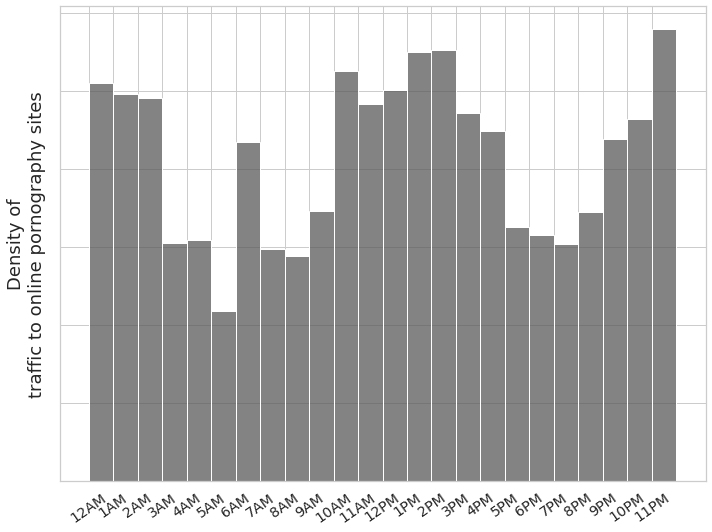

In [6]:
_scale = 2.5
_, ax = plt.subplots(figsize=(4*_scale,3*_scale))
sns.histplot(
    x="hour",
    data=df,
    bins=range(0,25), 
    stat="density",
    color=".35",
    ax=ax,
)

ax.set_xticks(hour_bins) # 0.5 is half of the "1" auto width
ax.set_xticklabels(hours_of_day, rotation=35)
ax.set_yticklabels([])

ax.set_xlabel("")
ax.set_ylabel("Density of\ntraffic to online pornography sites", fontsize=18,)

plt.tight_layout()
save_mpl_fig(os.path.join(FIGSAVEDIR, "time-of-day-consumption"))

59324


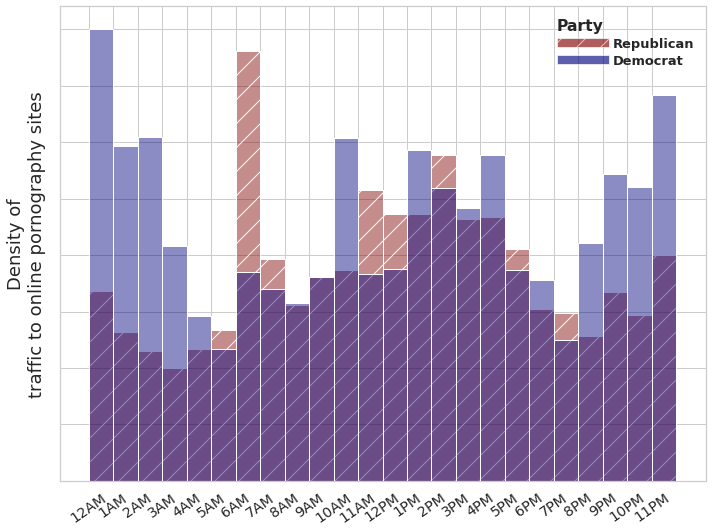

In [9]:
# Plot
_scale = 2.5
_, ax = plt.subplots(figsize=(4*_scale,3*_scale))
_df = df.query("party!='I'")
sns.histplot(x="hour", bins=range(0,25), stat="density",
             hue="party",
             common_norm=True,
             palette=["navy", "maroon"],
             alpha=.45,
             data=_df,
             ax=ax)
print(len(_df))

patch_opts = dict(edgecolor="1", alpha=.63, )
rep_hand = Patch(facecolor='maroon', label='Republican', hatch="/", **patch_opts)
dem_hand = Patch(facecolor='navy', label='Democrat', **patch_opts)

custom_legend = plt.legend(
    handles=[rep_hand, dem_hand], 
    handlelength=4, 
    handletextpad=.3,
    labelspacing=.3,
    title="Party", 
    frameon=False,
    loc="best",
    prop={'weight':'bold', "size":13},
)
custom_legend._legend_box.align = "left"
custom_legend.get_title().set_weight("bold")

hatch_pattern = "/"
for ix, container in enumerate(ax.containers):
    if ix==0:
        for rectangle in container:
            rectangle.set_hatch(hatch_pattern)
        
for ix, handle in enumerate(ax.get_legend().legend_handles):
    if ix==0:
        handle.set_hatch(hatch_pattern)
        
ax.set_xticks(hour_bins) # 0.5 is half of the "1" auto width
ax.set_yticklabels([])
ax.set_xticklabels(hours_of_day, rotation=35)
ax.set_xlabel("")
ax.set_ylabel("Density of\ntraffic to online pornography sites", fontsize=18,)
plt.tight_layout()
save_mpl_fig(os.path.join(FIGSAVEDIR, "time-of-day-consumption-by-party"))